<a href="https://colab.research.google.com/github/maskmo/yield-and-transfer-learning/blob/main/Yield_Assignment_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


36 berries simulated
4 bad berries simulated


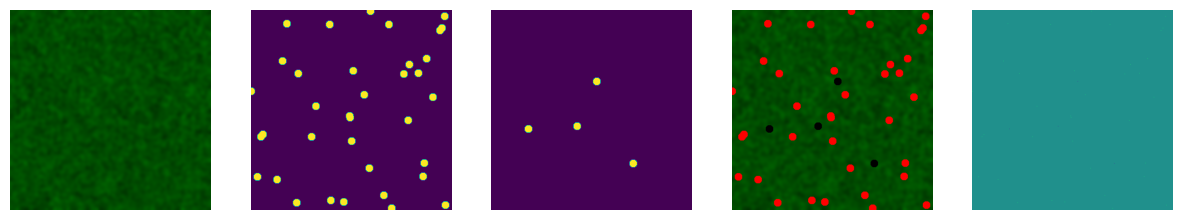

In [34]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw
import math
import random

FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 25 and 75 berries randomly placed
  percent_good = math.floor(10*random.random())
  random_int = np.random.randint(25, 75)
  num_berries = math.floor(random_int*percent_good/10)
  num_bad = math.floor(random_int*(1-percent_good/10))
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  bad_berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_bad)
  bad_berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_bad)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1
  label[bad_berry_cx,bad_berry_cy] = -1

  # draw the berries which are 10 px in radius
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    rr, cc = draw.disk(center = (berry_cx[idx], berry_cy[idx]),
                         radius=10,
                         shape=berries.shape)
    berries[rr, cc] = 1

  bad_berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(bad_berry_cx)):
    rr, cc = draw.disk(center = (bad_berry_cx[idx], bad_berry_cy[idx]),
                         radius=10,
                         shape=bad_berries.shape)
    bad_berries[rr, cc] = 1

  # add berries to the background
  img = np.copy(backgr)
  img[berries > 0] = [1, 0, 0] # red
  img[bad_berries > 0] = [0,0,0]

  if with_intermediates:
    print("{} berries simulated".format(num_berries))
    print("{} bad berries simulated".format(num_bad))
    if num_bad > num_berries:
      bad = True
    else:
      bad = False
    return backgr, berries, bad_berries, img, label
  else:
    return img, label

images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [37]:
## given an image, get the patches
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img,
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

In [38]:
# Getting input data
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      # print(len(patches) * num_full_images)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))
  )

trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(12288,) -1.0 0.0475243
(12288,) 0.0 0.068600394
(12288,) 0.0 0.076050505


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)       

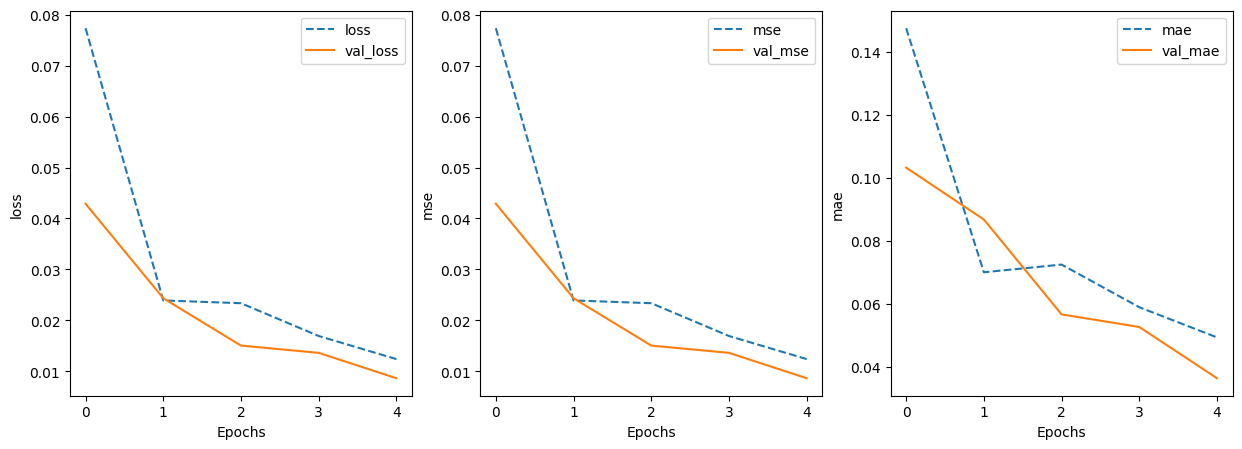

In [40]:
# Train
NUM_TRAIN = 20 # 10000 more realistic
NUM_EVAL = 2 # 1000 more realistic
NUM_EPOCHS = 5

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course
  # the patch is flattened, so we start by reshaping to an image
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer,
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()


15 berries simulated
10 bad berries simulated
8/8 [==============================] - 0s 4ms/step
5 berries simulated
53 bad berries simulated
8/8 [==============================] - 0s 3ms/step
30 berries simulated
7 bad berries simulated
8/8 [==============================] - 0s 3ms/step
4 berries simulated
41 bad berries simulated
8/8 [==============================] - 0s 5ms/step
11 berries simulated
45 bad berries simulated
8/8 [==============================] - 0s 3ms/step
14 berries simulated
56 bad berries simulated
8/8 [==============================] - 0s 3ms/step
36 berries simulated
8 bad berries simulated
8/8 [==============================] - 0s 3ms/step
29 berries simulated
12 bad berries simulated
8/8 [==============================] - 0s 3ms/step
3 berries simulated
35 bad berries simulated
8/8 [==============================] - 0s 3ms/step
56 berries simulated
14 bad berries simulated
8/8 [==============================] - 0s 3ms/step
14 berries simulated
58 bad berries

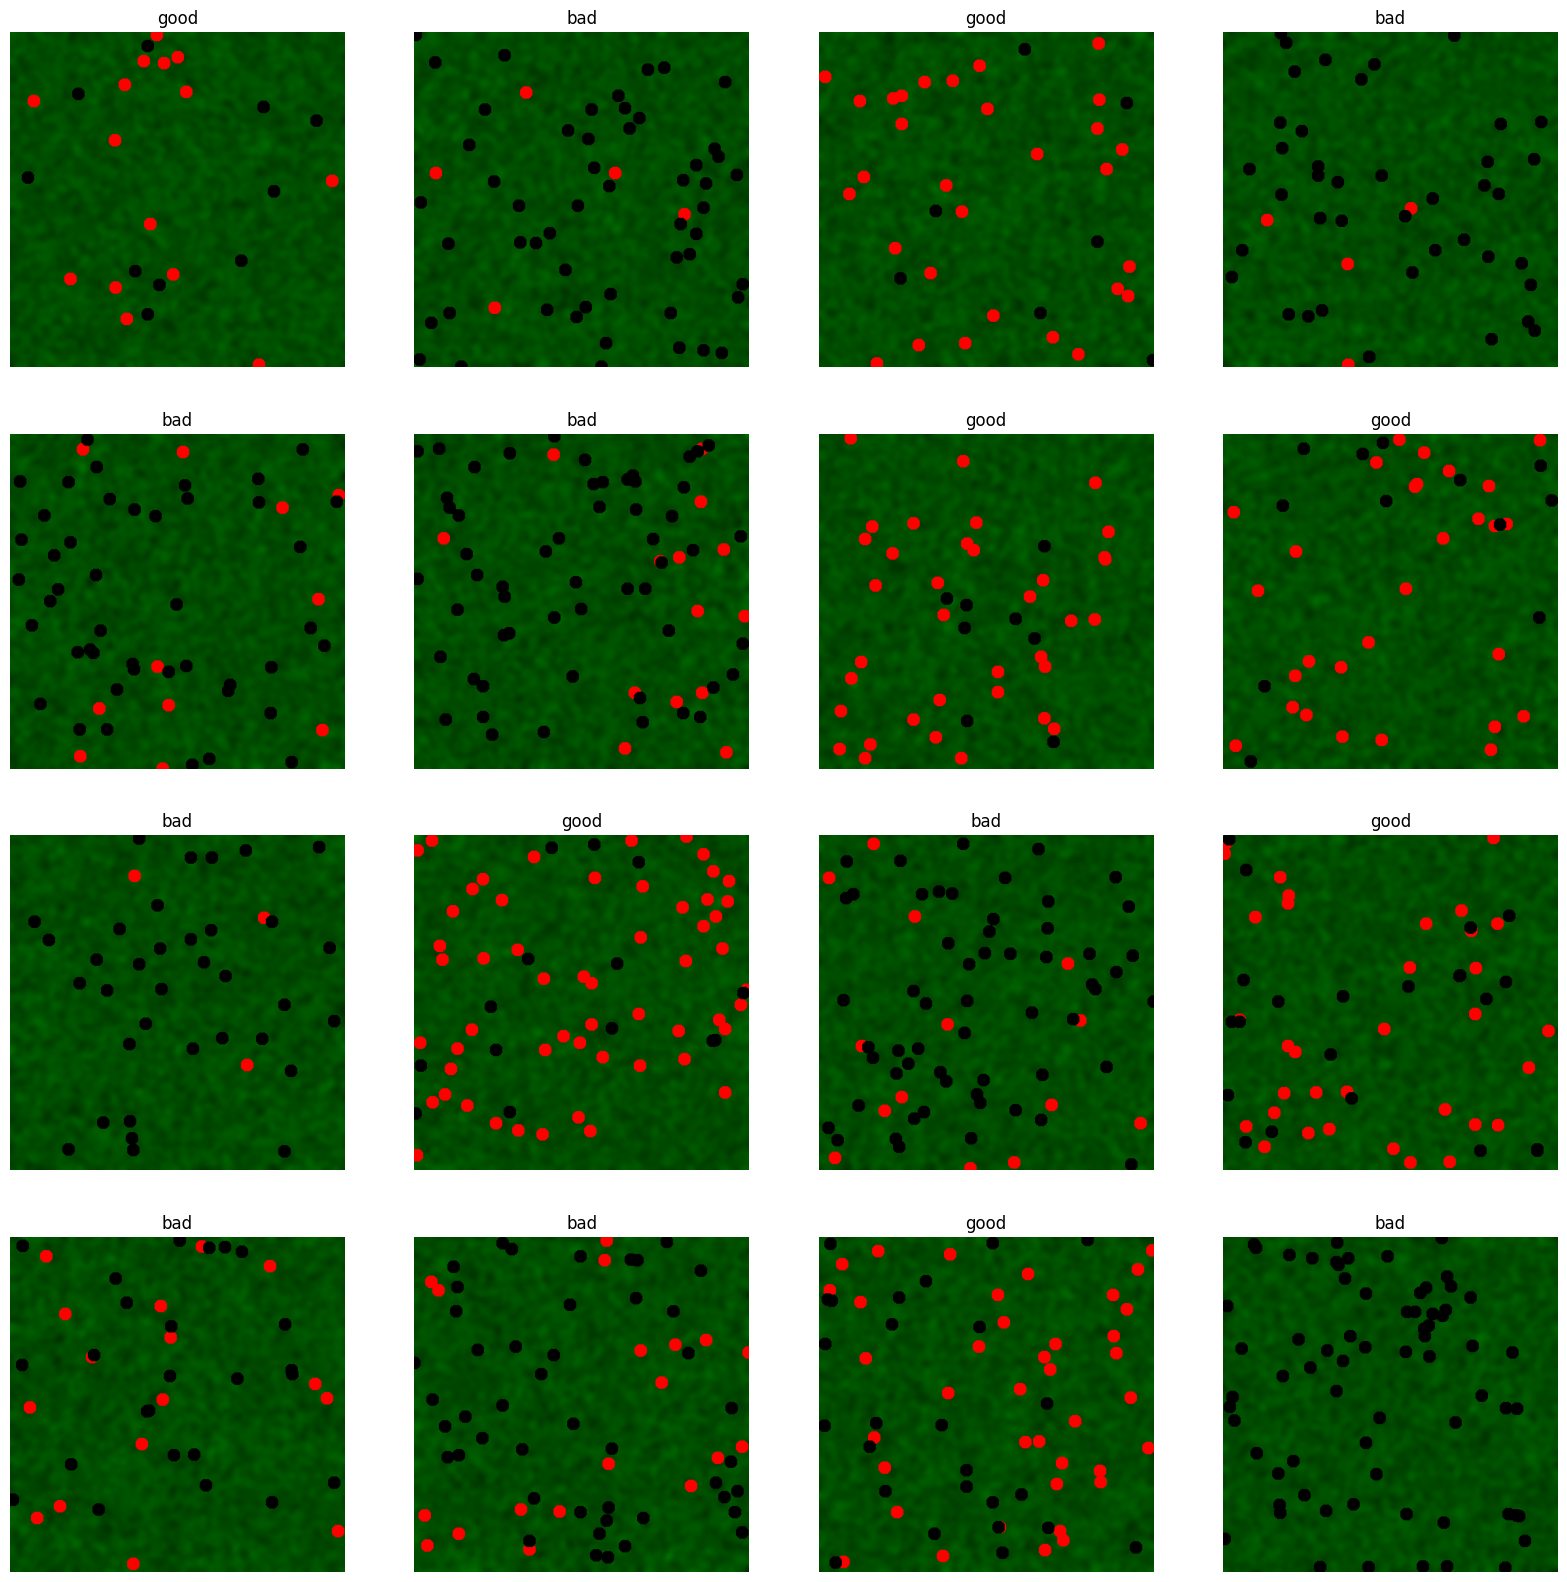

In [48]:
## prediction.
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, bad_berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  if count_berries(model, img).numpy() < 0:
    ax[idx//4, idx%4].set_title("bad".format())
  else:
    ax[idx//4, idx%4].set_title("good".format())
  ax[idx//4, idx%4].axis('off')